## Try to write down some texts and get the predictions

In [1]:
import os
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#!pip install neattext
import neattext.functions as nfx

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import demoji
demoji.download_codes()

import nltk
# nltk.download('wordnet')
from nltk.tokenize import TweetTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.tokenize.treebank import TreebankWordDetokenizer

from keras.preprocessing.text import Tokenizer, tokenizer_from_json
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Dense, LSTM, Embedding, Bidirectional, Dropout, Input, Conv1D, MaxPooling1D, Flatten, GlobalMaxPooling1D
from keras.models import load_model
import tensorflow as tf

/var/folders/24/nqjd68556n7_t8xcfyl1lvpc0000gn/T/ipykernel_60108/2035162933.py:18: FutureWarning: The demoji.download_codes attribute is deprecated and will be removed from demoji in a future version. It is an unused attribute as emoji codes are now distributed directly with the demoji package.
  demoji.download_codes()


## Load the model trained for the emotions prediction

In [2]:
# load model
model = load_model('how_do_you_feel_my_dear/final_model/model.h5')
# summarize model
model.summary()

2022-04-26 22:44:21.705123: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 50, 200)           2180000   
                                                                 
 dropout_27 (Dropout)        (None, 50, 200)           0         
                                                                 
 bidirectional_27 (Bidirecti  (None, 50, 100)          100400    
 onal)                                                           
                                                                 
 dropout_28 (Dropout)        (None, 50, 100)           0         
                                                                 
 bidirectional_28 (Bidirecti  (None, 50, 300)          301200    
 onal)                                                           
                                                                 
 dropout_29 (Dropout)        (None, 50, 300)          

In [3]:
# alphabetical order
# 0: anger
# 1: fear
# 2: joy
# 3: sadness

## Load the tokenizer on which we trained our model
If you use another tokenizer it is not going to work

In [4]:
with open('how_do_you_feel_my_dear/tokenizer/tokenizer.json') as f:
    data_json = json.load(f)

tokenizer = tokenizer_from_json(data_json)

In [7]:
def clean_emoji_output(text):
    return re.sub(":", " ", text)

def strip_lowercase(text):
    return text.strip().lower()

# tokenize
tt = TweetTokenizer()

# lemmatize
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]

# function which cleans texts
def clean_text(data):
    data['clean_text'] = data['text'].apply(nfx.remove_emails)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_numbers)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_urls)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_userhandles)
    data['clean_text'] = data['clean_text'].apply(demoji.replace_with_desc)
    data['clean_text'] = data['clean_text'].apply(clean_emoji_output)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_special_characters)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_bad_quotes)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_html_tags)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_punctuations)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_stopwords)
    data['clean_text'] = data['clean_text'].apply(nfx.remove_multiple_spaces)
    data['clean_text'] = data['clean_text'].apply(strip_lowercase)
    
    data['tokenize'] = data.clean_text.str.lower().apply(tt.tokenize)
    data['tokenize_lemmatized'] = data['tokenize'].apply(lemmatize_text)
    
    # detokenize
    data['final_text'] = data.tokenize_lemmatized.apply(TreebankWordDetokenizer().detokenize)

In [8]:
stringhe = ["hello to EVERYbody, I'm here because I'm happy",
            "So sad, what Happened yesterday, many #deaths",
            "@andrea I want to kill you, no matter how far you are, I will find you",
            "@mathias that way scares me a lot°çççéé"]

data = pd.DataFrame({"text": stringhe})
data

,text
0,"hello to EVERYbody, I'm here because I'm happy"
1,"So sad, what Happened yesterday, many #deaths"
2,"@andrea I want to kill you, no matter how far ..."
3,@mathias that way scares me a lot°çççéé


In [9]:
# clean and shuffle

clean_text(data)
data

,text,clean_text,tokenize,tokenize_lemmatized,final_text
0,"hello to EVERYbody, I'm here because I'm happy",hello everybody im im happy,"[hello, everybody, im, im, happy]","[hello, everybody, im, im, happy]",hello everybody im im happy
1,"So sad, what Happened yesterday, many #deaths",sad happened yesterday deaths,"[sad, happened, yesterday, deaths]","[sad, happened, yesterday, death]",sad happened yesterday death
2,"@andrea I want to kill you, no matter how far ...",want kill matter far find,"[want, kill, matter, far, find]","[want, kill, matter, far, find]",want kill matter far find
3,@mathias that way scares me a lot°çççéé,way scares lot,"[way, scares, lot]","[way, scare, lot]",way scare lot


In [10]:
# Convert texts into some numeric sequences and make the length of all numeric sequences equal 

X_seq = tokenizer.texts_to_sequences(data.final_text) 
X_pad = pad_sequences(X_seq, maxlen = 50, padding = 'post') 

X_pad = np.array(X_pad)
X_pad[:3]

array([[ 995, 1332,    2,    2,   15,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [  31,  570,  468,  491,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0],
       [  16,  342,  467,  310,   98,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,   

In [11]:
data.final_text[:3]

0     hello everybody im im happy
1    sad happened yesterday death
2       want kill matter far find
Name: final_text, dtype: object

In [12]:
model.predict(X_pad)

array([[0.00932676, 0.00625352, 0.97586864, 0.00855107],
       [0.02307396, 0.13095938, 0.11437412, 0.7315926 ],
       [0.9695867 , 0.01440939, 0.00753933, 0.00846465],
       [0.00296482, 0.9935203 , 0.00148988, 0.00202487]], dtype=float32)

In [13]:
data['prediction'] = np.argmax(model.predict(X_pad), axis=1)

# alphabetical order
# 0: anger
# 1: fear
# 2: joy
# 3: sadness

code_to_strings = {0: "anger",
                   1: "fear",
                   2: "joy",
                   3: "sadness"}

data["prediction"] = data["prediction"].map(code_to_strings)
data.head()

,text,clean_text,tokenize,tokenize_lemmatized,final_text,prediction
0,"hello to EVERYbody, I'm here because I'm happy",hello everybody im im happy,"[hello, everybody, im, im, happy]","[hello, everybody, im, im, happy]",hello everybody im im happy,joy
1,"So sad, what Happened yesterday, many #deaths",sad happened yesterday deaths,"[sad, happened, yesterday, deaths]","[sad, happened, yesterday, death]",sad happened yesterday death,sadness
2,"@andrea I want to kill you, no matter how far ...",want kill matter far find,"[want, kill, matter, far, find]","[want, kill, matter, far, find]",want kill matter far find,anger
3,@mathias that way scares me a lot°çççéé,way scares lot,"[way, scares, lot]","[way, scare, lot]",way scare lot,fear


<AxesSubplot:>

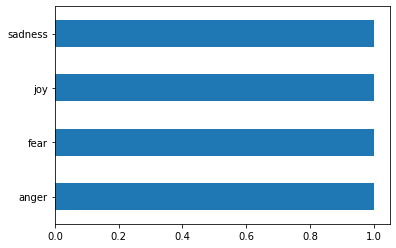

In [14]:
data.prediction.value_counts().sort_index(ascending=True).plot(kind='barh')